In [1]:
from rdflib import Graph, URIRef
import numpy as np
import glob 

ONLY_ORGANIC = False

graph = Graph()
for filename in glob.glob('only_organic_reduced_kgs/reduced_*' if ONLY_ORGANIC else 'reduced_kgs/reduced_*'):
    graph.load(filename,format=filename.split('.')[-1])

In [2]:
len(graph)

235202

In [3]:
TRAINING = True

In [4]:
entities = sorted(list(set(graph.subjects()) | set(graph.objects())))
relations = sorted(list(set(graph.predicates())))
len(entities), len(relations)

(59953, 185)

In [5]:
entity_mappings = {e:i for i,e in enumerate(entities)}
relation_mappings = {e:i for i,e in enumerate(relations)}
triples = np.asarray(list(map(lambda x: (entity_mappings[x[0]],
                                         relation_mappings[x[1]],
                                         entity_mappings[x[2]]),graph)))

In [6]:
def min_distance_loss(w,epsilon=1.0):
        
    r = tf.reduce_sum(w*w, 1)

    r = tf.reshape(r, [-1, 1])
    D = r - 2*tf.matmul(w, tf.transpose(w)) + tf.transpose(r)
    D = D + tf.linalg.diag(epsilon * tf.ones(D.shape[0]))
    return tf.reduce_sum(tf.where(D<epsilon,1.0,0.0))/tf.cast(w.shape[1],tf.float32)

In [7]:
import tensorflow as tf
from embedding_model import DistMult, ComplEx, TransE, ConvE

In [8]:
def create_negative(postive,n=2):
    negative = np.repeat(postive,n,axis=0)
    negative[:,0] = np.random.randint(0,len(entities),size=len(negative))
    negative[:,2] = np.random.randint(0,len(entities),size=len(negative))
    return negative

In [9]:
%timeit create_negative(triples,n=10)

38.2 ms ± 273 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:

import tqdm.notebook as tq

embedding_model = ComplEx(entities,relations)

best_loss = float('inf')
losses = []
patience=10

if TRAINING:

    for i in tq.tqdm(range(100)):

        negative = create_negative(triples,n=32)

        X = np.concatenate([triples,negative],axis=0)
        y = np.concatenate([np.ones(len(triples)),-1*np.ones(len(negative))],axis=0)

        hist = embedding_model.fit((X,y),y,
                         batch_size=8192,
                         shuffle=True,
                         verbose=0)

        l = hist.history['loss'][-1]
        losses.append(l)
        if l < best_loss:
            best_loss = l
            c = 0
        else:
            c += 1

        if c > patience: break
    
    embedding_model.save_weights('only_organic_model.tf' if ONLY_ORGANIC else 'model.tf')
else:
    embedding_model.load_weights('only_organic_model.tf' if ONLY_ORGANIC else 'model.tf')
    

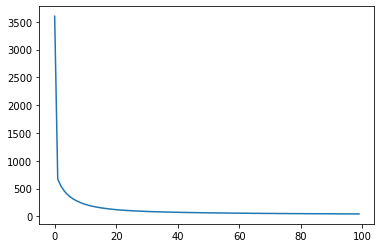

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
if TRAINING:
    plt.plot(losses)

In [12]:
import pandas as pd

effect_data = pd.read_csv('only_organic_effect_data_extra.csv' if ONLY_ORGANIC else 'effect_data_extra.csv')
ent = set(map(str,entities))
effect_data = effect_data[effect_data['species'].isin(ent)]
effect_data = effect_data[effect_data['chemical'].isin(ent)]
effect_data = effect_data[effect_data['smiles_clusters']>=0].reset_index(drop=True)

In [13]:
fps = {}

import sys
from SPARQLWrapper import SPARQLWrapper, JSON
from pubchempy import Compound

endpoint_url = "https://query.wikidata.org/sparql"

query = """select ?cas ?pc where {
  ?c wdt:P231 ?tmp ;
     wdt:P662 ?pc .
  bind(replace(?tmp,'-','') as ?cas)
}"""


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

try: 
    fps = pd.read_pickle('fingerprints.pkl')

except FileNotFoundError:
    
    results = get_results(endpoint_url, query)
    for result in tq.tqdm(results["results"]["bindings"]):
        chem_id = 'https://cfpub.epa.gov/ecotox/cas/'+result['cas']['value']
        if chem_id in set(effect_data.chemical.values): 
            vioxx = Compound.from_cid(int(result['pc']['value']))
            fps[chem_id] = vioxx.fingerprint
    pd.to_pickle(fps,'fingerprints.pkl')


In [14]:
def to_bin(he): 
    scale = 16 ## equals to hexadecimal
    num_of_bits = 900
    return bin(int(he, scale))[2:].zfill(num_of_bits)

effect_data['fp'] = [to_bin(fps[c]) if c in fps else to_bin('0') for c in effect_data['chemical'].values]

In [15]:
effect_data = effect_data[effect_data['fp']!=to_bin('0')]
effect_data.shape

(7121, 11)

In [16]:
effect_data.head()

,Unnamed: 0,Unnamed: 0.1,species,chemical,conc (mol/L),species_divisions,species_others,subClassOf,smiles,smiles_clusters,fp
0,0,0,https://cfpub.epa.gov/ecotox/taxon/1,https://cfpub.epa.gov/ecotox/cas/10025919,3.051629,https://cfpub.epa.gov/ecotox/group/Fish,https://cfpub.epa.gov/ecotox/group/StandardTes...,NaN,Cl[Sb](Cl)Cl,4,0011011100010000000000000000000000000000000000...
1,1,1,https://cfpub.epa.gov/ecotox/taxon/1,https://cfpub.epa.gov/ecotox/cas/10028156,5.681105,https://cfpub.epa.gov/ecotox/group/Fish,https://cfpub.epa.gov/ecotox/group/StandardTes...,NaN,[O-][O+]=O,4,0011011100010000000000000000001100000000000000...
2,2,2,https://cfpub.epa.gov/ecotox/taxon/1,https://cfpub.epa.gov/ecotox/cas/100414,3.398977,https://cfpub.epa.gov/ecotox/group/Fish,https://cfpub.epa.gov/ecotox/group/StandardTes...,http://purl.obolibrary.org/obo/CHEBI_33832,CCC1=CC=CC=C1,2,0011011100011100000001110000000000000000000000...
3,3,3,https://cfpub.epa.gov/ecotox/taxon/1,https://cfpub.epa.gov/ecotox/cas/100425,3.512146,https://cfpub.epa.gov/ecotox/group/Fish,https://cfpub.epa.gov/ecotox/group/StandardTes...,"http://purl.obolibrary.org/obo/CHEBI_134179,ht...",C=CC1=CC=CC=C1,2,0011011100011100000001110000000000000000000000...
4,4,4,https://cfpub.epa.gov/ecotox/taxon/1,https://cfpub.epa.gov/ecotox/cas/10043013,3.127255,https://cfpub.epa.gov/ecotox/group/Fish,https://cfpub.epa.gov/ecotox/group/StandardTes...,NaN,O=S1(=O)O[Al]2OS(=O)(=O)O[Al](O1)OS(=O)(=O)O2,4,0011011100010000000000000000001111000000000001...


In [17]:
data = effect_data[['fp','species','chemical','conc (mol/L)']].values

In [18]:
data = np.asarray([[fp,
                    entity_mappings[URIRef(s)],
                    entity_mappings[URIRef(c)],
                    conc] for fp,s,c,conc in data])

In [19]:
embedding_model.trainable=False
from tensorflow.keras.layers import Concatenate, BatchNormalization, Activation, Input, Dense, Dropout, Embedding
from tensorflow.keras.models import Model
def mlp(input_shape,use_embedding=False):
    
    inp_s = Input(())
    inp_c = Input(())
    inp = Input(input_shape)
    
    if use_embedding:
        s = embedding_model.get_layer('entity_embedding')(inp_s)
        c = embedding_model.get_layer('entity_embedding')(inp_c)
    else:
        el = Embedding(len(entities),200)
        s = el(inp_s)
        c = el(inp_c)
    
    x = Concatenate(axis=-1)([s,c])
    x = Dense(128)(x)
    x = Activation('relu')(x)
    
    x = Dropout(0.2)(x)
    x = Dense(1)(x)
    model = Model(inputs=[inp,inp_s,inp_c],outputs=x)
    model.compile(optimizer='adam',loss='mse')
    return model
   
    

In [20]:
def create_autoencoder(dim):
    encoder = tf.keras.models.Sequential([Dropout(0.2),Dense(200)])
    model = tf.keras.models.Sequential([encoder,Dropout(0.2),Dense(dim,activation='sigmoid')])
    model.compile(optimizer='adam',loss='binary_crossentropy')
    return model, encoder
    

In [21]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
        
def kfold_group(X,y,groups,k=5):
    
    group_idx = [np.random.permutation(np.where(groups==g)[0]) for g in np.unique(groups)]
    
    folds = []
    
    for j,g in enumerate(group_idx):
        g_fold = []
        for l in np.array_split(g,k):
            g_fold.append(l)
        folds.append(g_fold)
        
    for i in range(k):
        test = np.concatenate([folds[j][i] for j in range(len(group_idx))])                          
        train = np.concatenate([np.concatenate([folds[j][m] for j in range(len(group_idx))]) for m in range(k) if m!=i]).ravel()
        
        yield train,test
        

In [22]:
#kmeans on pubchem fp
from sklearn.cluster import KMeans
X = data[:,0]
X = np.asarray(list(map(lambda x: np.asarray([float(a) for a in x]), X))).astype('float32')
kmeans = KMeans(5)
kmeans.fit(X)
effect_data['pc_fp_cluster'] = kmeans.predict(X).ravel()

In [23]:
from sklearn.model_selection import KFold, GroupKFold, GroupShuffleSplit, LeaveOneGroupOut, StratifiedKFold
from sklearn.metrics import r2_score
import random

Xs,Xc = data[:,1].astype(int),data[:,2].astype(int)
y = data[:,3].astype('float32')
X = data[:,0]

X = np.asarray(list(map(lambda x: np.asarray([float(a) for a in x]), X))).astype('float32')

groups = effect_data['smiles_clusters'].values
folds = 5

seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
N = 10

scores = []

oof = np.zeros(y.shape)
oof_embedding = np.zeros(y.shape)

for _ in tq.tqdm(range(N)):

    oof_this_seed = np.zeros(y.shape)
    oof_this_seed_embedding = np.zeros(y.shape)
    
    for i,(train,test) in tq.tqdm(enumerate(kfold_group(X,y,groups=groups,k=folds)),
                                  total=folds,
                                  desc='Folds',
                                  leave=False):

        model = mlp(X.shape[-1],use_embedding=False)
        model.fit((X[train],Xs[train],Xc[train]),y[train],
                  validation_data=((X[test],Xs[test],Xc[test]),y[test]),
                  batch_size=8192,epochs=1000,verbose=0,
                 callbacks=[tf.keras.callbacks.EarlyStopping('val_loss',patience=10,restore_best_weights=True)])

        p = model.predict((X[test],Xs[test],Xc[test])).ravel()
        oof[test] += p/N
        oof_this_seed[test] += p

        model = mlp(X.shape[-1],use_embedding=True)
        model.fit((X[train],Xs[train],Xc[train]),y[train],
                  validation_data=((X[test],Xs[test],Xc[test]),y[test]),
                  batch_size=8192,epochs=1000,verbose=0,
                 callbacks=[tf.keras.callbacks.EarlyStopping('val_loss',patience=10,restore_best_weights=True)])
        p = model.predict((X[test],Xs[test],Xc[test])).ravel()
        oof_embedding[test] += p/N
        oof_this_seed_embedding[test] += p
        
    scores.append([r2_score(y,oof_this_seed),r2_score(y,oof_this_seed_embedding)])

s,s_embedding = np.split(np.asarray(scores),2,axis=1)

'Out-of-fold R^2',np.mean(s),'+-',np.std(s),'Embedding:',np.mean(s_embedding),'+-',np.std(s)

('Out-of-fold R^2',
 0.4079681339666599,
 '+-',
 0.0036674889236497257,
 'Embedding:',
 0.46708488671970505,
 '+-',
 0.0036674889236497257)

In [24]:
pd.DataFrame(data=dict(species=effect_data.species,chemical=effect_data.chemical,prediction=oof)).to_csv('only_organic_predictions.csv' if ONLY_ORGANIC else 'predictions.csv')
pd.DataFrame(data=dict(species=effect_data.species,chemical=effect_data.chemical,prediction=oof_embedding)).to_csv('only_organic_predictions_embedding.csv' if ONLY_ORGANIC else 'predictions_embedding.csv')